Starting the aberration basis...
Running Gram-Schmidt...
Testing the created method...
Plotting the residual...


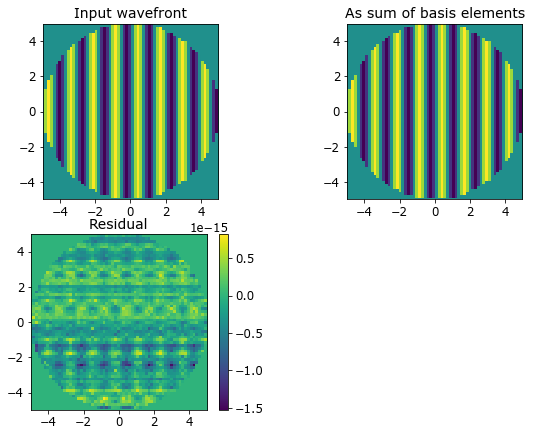

In [29]:
from hcipy import *
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg

N = 64
D = 9.96
aperture = circular_aperture(D)
pupil_grid = make_pupil_grid(N, D)
sps = 40 * N // 128
pupsep = 1
outgrid_size = int(np.ceil(sps * (pupsep + 1)))
D_grid = 3.6e-3
pyramid_grid = make_pupil_grid(N, D_grid)
nonzero_size = aperture(pupil_grid)[aperture(pupil_grid) > 0].size

def get_sub_images(electric_field):
    pyramid_grid = make_pupil_grid(N, D_grid)
    images = Field(np.asarray(electric_field).ravel(), pyramid_grid)
    pysize = int(np.sqrt(images.size))
    images.shape = (pysize, pysize)
    sub_images = [images[pysize-sps-1:pysize-1, 0:sps], images[pysize-sps-1:pysize-1, pysize-sps-1:pysize-1],
                  images[0:sps, 0:sps], images[0:sps, pysize-sps-1:pysize-1]]
    subimage_grid = make_pupil_grid(sps, D_grid * sps / N)
    for count, img in enumerate(sub_images):
        img = img.ravel()
        img.grid = subimage_grid
        sub_images[count] = img
    return sub_images

def pyramid_prop(wf):
    # Given a wavefront, returns the result of a pyramid propagation and splitting into sub-images,
    # as a list of hcipy Field objects.
    keck_pyramid = PyramidWavefrontSensorOptics(pupil_grid, pupil_separation=pupsep, num_pupil_pixels=sps)
    return get_sub_images(keck_pyramid.forward(wf).electric_field)

def estimate(images_list):
    EstimatorObject = PyramidWavefrontSensorEstimator(aperture, make_pupil_grid(sps*2, D_grid*sps*2/N))
    I_b = images_list[0]
    I_a = images_list[1]
    I_c = images_list[2]
    I_d = images_list[3]
    norm = I_a + I_b + I_c + I_d
    I_x = (I_a + I_b - I_c - I_d) / norm
    I_y = (I_a - I_b - I_c + I_d) / norm
    pygrid = make_pupil_grid(sps)
    return Field(I_x.ravel(), pygrid), Field(I_y.ravel(), pygrid)

def make_slopes(wf):
    x, y = estimate(pyramid_prop(wf))
    return np.concatenate((x, y))

def plot_on_aperture(aperture, field):
    project_onto = Wavefront(aperture(pupil_grid)).electric_field
    project_onto.shape = (N, N)

    count, i, j = 0, 0, 0
    while count < nonzero_size:
        if np.real(project_onto[i][j]) > 0:
            project_onto[i][j] = field[count]
            count += 1
        j += 1
        if j == N - 1:
            j = 0
            i += 1
    return project_onto.ravel() * aperture(pupil_grid)

def least_inv(A):
    # given a matrix A such that Ax = b, makes a least-squares matrix Y such that
    # x^ = Yb.
    return np.linalg.inv(A.T.dot(A)).dot(A.T)

def pupil_sin_phase(pupil, wavsx=1, wavsy=0, amplitude=0.1):
    size=int(np.sqrt(pupil.size))
    x=np.arange(size)
    y=np.arange(size)
    sin = np.zeros((size,size))

    if wavsx==0 and wavsy==0:
        return pupil
    elif wavsy==0:
        yfreq=0
        xfreq = 2*np.pi/((size/wavsx))
    elif wavsx==0:
        xfreq=0
        yfreq = 2*np.pi/((size/wavsy))
    else:
        xfreq = 2*np.pi/((size/wavsx))
        yfreq = 2*np.pi/((size/wavsy))

    for i in range(len(x)):
        for j in range(len(y)):
            sin[i,j] = amplitude*np.sin(xfreq*i+yfreq*j)

    return pupil*np.exp(complex(0,1)*sin).ravel()

wf = Wavefront(aperture(pupil_grid))
b = nonzero_size//2
print("Starting the aberration basis...")
aberration_mode_basis = []
for i in np.arange(0, b, 1):
    aberration_mode_basis.append(pupil_sin_phase(wf.electric_field, i + 1, 0))
for i in np.arange(0, b, 1):
    aberration_mode_basis.append(pupil_sin_phase(wf.electric_field, 0, i + 1))

#print("Making the pyramid basis...")
#pyramid_basis = np.asarray([make_slopes(Wavefront(x)) for x in aberration_mode_basis])
aberration_mode_basis = np.asarray([x[aperture(pupil_grid) > 0] for x in aberration_mode_basis])

print("Running Gram-Schmidt...")
orthogonalized = []
for x in aberration_mode_basis:
    y = x
    for v in orthogonalized:
        y -= (x.dot(v)/v.dot(v))*v
    if not (np.allclose(y, np.zeros(y.shape))):
        orthogonalized.append(y)

def make_best_sine_approximation(wf):
    S = np.asarray(orthogonalized).T
    inversion = np.linalg.inv(S.T.dot(S))
    least_square = S.dot(inversion).dot(S.T)
    return Wavefront(Field(least_square.dot(wf.electric_field[aperture(pupil_grid) > 0]), wf.grid))

print("Testing the created method...")
original_electric = Field(pupil_sin_phase(wf.electric_field, 0, 8), wf.grid)
original = Wavefront(original_electric)
as_basis_electric = Field(plot_on_aperture(aperture, make_best_sine_approximation(original).electric_field), wf.grid)
as_basis_c = Wavefront(as_basis_electric)

print("Plotting the residual...")
plt.subplot(2,2,1)
imshow_field(original.phase)
plt.title("Input wavefront")
plt.subplot(2,2,2)
imshow_field(as_basis_c.phase)
plt.title("As sum of basis elements")
plt.subplot(2,2,3)
imshow_field(original.phase - as_basis_c.phase)
plt.title("Residual")
plt.colorbar()
plt.show()